<a href="https://colab.research.google.com/github/armand010/PCVK_Ganjil_2024/blob/main/PCVK_Kuis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2 as T
from torchvision import models
import matplotlib.pyplot as plt
import random
import torch.optim as optim

# Set Device

In [ ]:
# (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Preprocessing

## Class Load Data

In [ ]:
class ArtImageDataset(Dataset):
    """
    Class untuk load gambar pada dataset AI-generate dan real art.
    """
    def __init__(self, ai_art_path, real_art_path):
        """
        Memberikan label pada masing-masing path gambar.

        Ket.:
            ai_art_path (str): Path gambar AI-generated
            real_art_path (str): Path gambar real
        """
        self.data = []
        # Load real art images (label 0)
        for p in glob.glob(real_art_path):
            self.data.append([p, 0])
        # Load AI-generated art images (label 1)
        for p in glob.glob(ai_art_path):
            self.data.append([p, 1])
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Load serta preprocess gambar yang telah dilabeli
        """
        image_path, label = self.data[index]
        image = read_image(image_path)

        # Transform pipeline
        transform = T.Compose([
            T.Resize((300, 300), antialias=True),
            T.Lambda(lambda x: x.repeat(3,1,1) if x.size(0) == 1 else x),  # Handle grayscale
            T.Lambda(lambda x: x[:3,:,:] if x.size(0) == 4 else x),  # Handle RGBA
            T.ToDtype(torch.float, scale=True),
            T.ToPureTensor()
        ])

        return transform(image), label

## Function for Make Model VGG16

In [ ]:
def model_vgg16():
    """
    Fungsi untuk membuat model VGG16 untuk klasifikasi.
    """
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    # Freeze feature extraction layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify classifier for binary classification
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features, 100),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(100, 2),
        nn.Softmax(dim=1)
    )
    return model

## Function for Train Epoch 1 Times

In [ ]:
def train_epoch(model, loader, loss_fn, optimizer):
    """
    Train model untuk 1 epoch
    """
    model.train()
    total_loss = 0
    batch_count = 0

    for i, (images, targets) in enumerate(loader):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count = i + 1

        if i % 100 == 0:
            print(f"Batch {i}, Loss: {loss.item():.4f}")

    return total_loss / batch_count

## Function for Evaluate Model

In [ ]:
def evaluate_model(model, loader, loss_fn):
    """
    Evalasi model pada data test untuk mendapatkan nilai loss, precision, recall, dan accuracy.
    """
    model.eval()
    total_loss = 0
    TP = TN = FP = FN = 0
    batch_count = 0

    with torch.no_grad():
        for i, (images, targets) in enumerate(loader):
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)
            loss = loss_fn(predictions, targets)

            # Update metrics
            is_ai_pred = predictions[0][1].item() > 0.5
            is_ai_true = targets[0].item() == 1

            if is_ai_true:
                if is_ai_pred:
                    TP += 1
                else:
                    FN += 1
            else:
                if is_ai_pred:
                    FP += 1
                else:
                    TN += 1

            total_loss += loss.item()
            batch_count = i + 1

    total = TP + TN + FP + FN
    precision = float(TP) / float(TP + FP) if (TP + FP) > 0 else 0
    recall = float(TP) / float(TP + FN) if (TP + FN) > 0 else 0
    accuracy = float(TP + TN) / float(total)

    print("\nEvaluation Results:")
    print(f"Total test images: {total}")
    print(f"True Positives: {TP}, True Negatives: {TN}")
    print(f"False Positives: {FP}, False Negatives: {FN}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    return total_loss / batch_count, precision, recall, accuracy

# Train Model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]



Evaluation Results:
Total test images: 100
True Positives: 9, True Negatives: 33
False Positives: 4, False Negatives: 54
Precision: 0.69
Recall: 0.14
Accuracy: 0.42

Epoch 1/10
Batch 0, Loss: 0.6815
Batch 100, Loss: 0.7065
Batch 200, Loss: 0.7403

Evaluation Results:
Total test images: 100
True Positives: 36, True Negatives: 34
False Positives: 3, False Negatives: 27
Precision: 0.92
Recall: 0.57
Accuracy: 0.70

Epoch 2/10
Batch 0, Loss: 0.5357
Batch 100, Loss: 0.3236
Batch 200, Loss: 0.3383

Evaluation Results:
Total test images: 100
True Positives: 48, True Negatives: 26
False Positives: 11, False Negatives: 15
Precision: 0.81
Recall: 0.76
Accuracy: 0.74

Epoch 3/10
Batch 0, Loss: 0.3229
Batch 100, Loss: 0.3142
Batch 200, Loss: 0.5447

Evaluation Results:
Total test images: 100
True Positives: 51, True Negatives: 27
False Positives: 10, False Negatives: 12
Precision: 0.84
Recall: 0.81
Accuracy: 0.78

Epoch 4/10
Batch 0, Loss: 0.4006
Batch 100, Loss: 0.5403
Batch 200, Loss: 0.5153

Ev

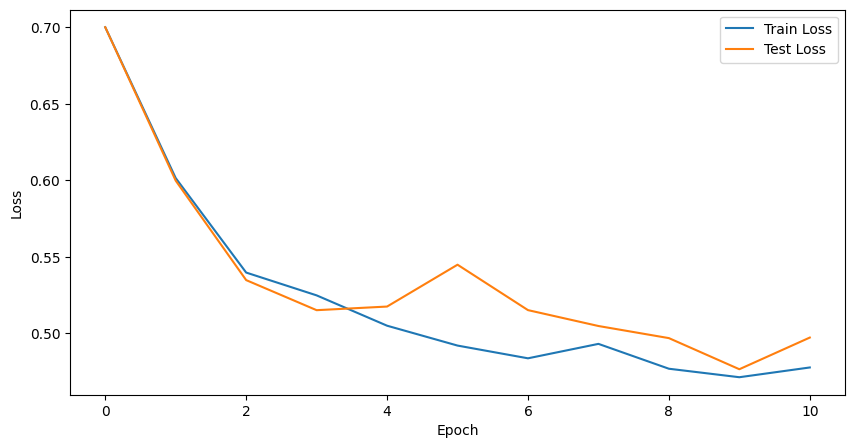

In [ ]:
def main():
    """
    Fungsi untuk memakai fungsi-fungsi yang telah didefinisikan sebelumnya untuk training model.
    """
    # Dataset paths
    AI_ART_PATH = "/content/drive/MyDrive/PCVK/kuis2_dataset/kuis/AiArtData/AiArtData/*"
    REAL_ART_PATH = "/content/drive/MyDrive/PCVK/kuis2_dataset/kuis/RealArt/RealArt/*"

    # Create dataset and dataloaders
    dataset = ArtImageDataset(AI_ART_PATH, REAL_ART_PATH)
    train_size = len(dataset) - 100
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, 100]
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Initialize model
    model = model_vgg16()

    model.to(device)

    # Training setup
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 10

    # Training loop
    train_losses = []
    test_losses = []

    # Initial evaluation
    initial_loss, *_ = evaluate_model(model, test_loader, loss_fn)
    train_losses.append(initial_loss)
    test_losses.append(initial_loss)

    # Training
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        test_loss, precision, recall, accuracy = evaluate_model(model, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'BestModel.pth')

# Gunakan fungsi main
if __name__ == "__main__":
    main()

# Run/Use Model

Using device: cpu
Model loaded successfully!

Enter image path (or 'q' to quit): /content/real2.webp


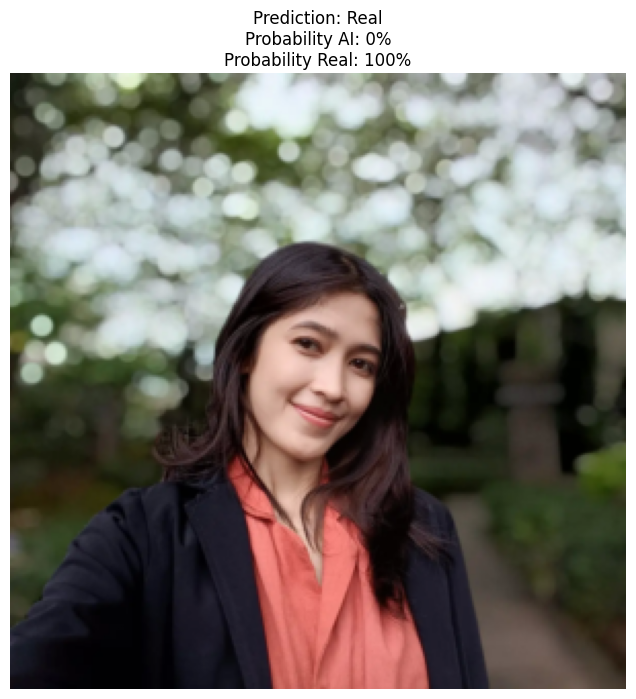


Prediction Results:
Class: Real
Probability AI: 0%
Probability Real: 100%

Enter image path (or 'q' to quit): /content/ai.png


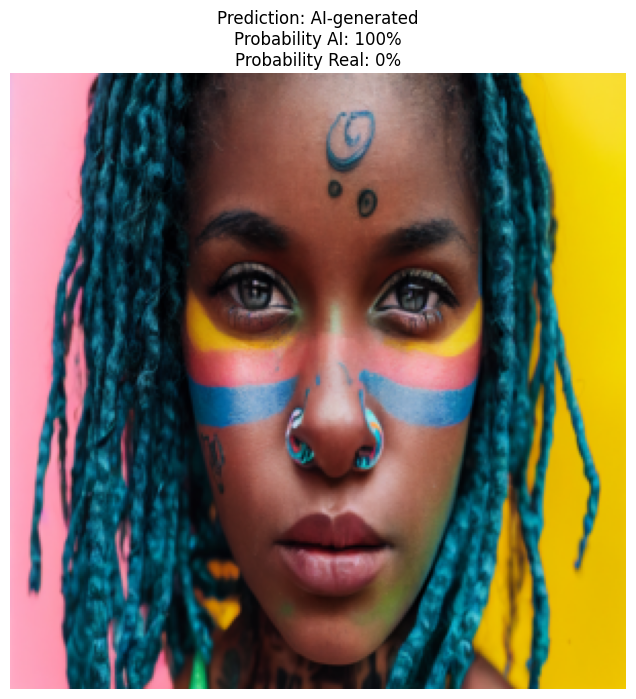


Prediction Results:
Class: AI-generated
Probability AI: 100%
Probability Real: 0%

Enter image path (or 'q' to quit): /content/naruto.webp


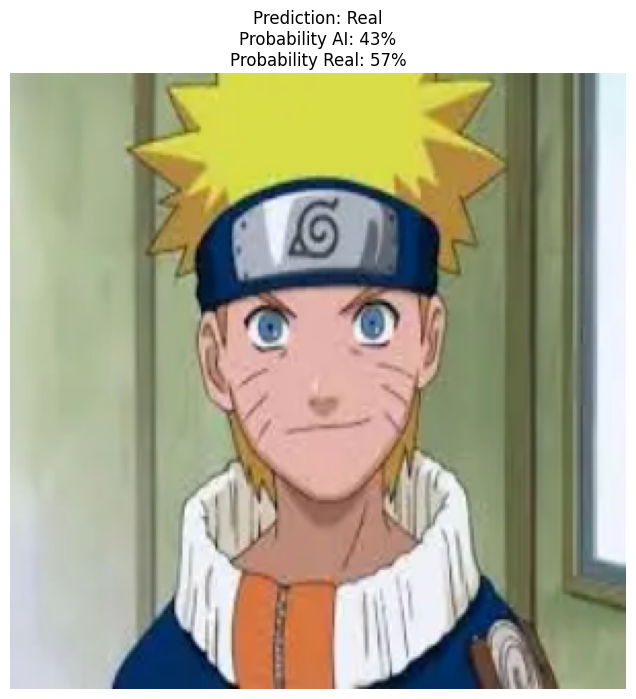


Prediction Results:
Class: Real
Probability AI: 43%
Probability Real: 57%

Enter image path (or 'q' to quit): /content/real3.jpg


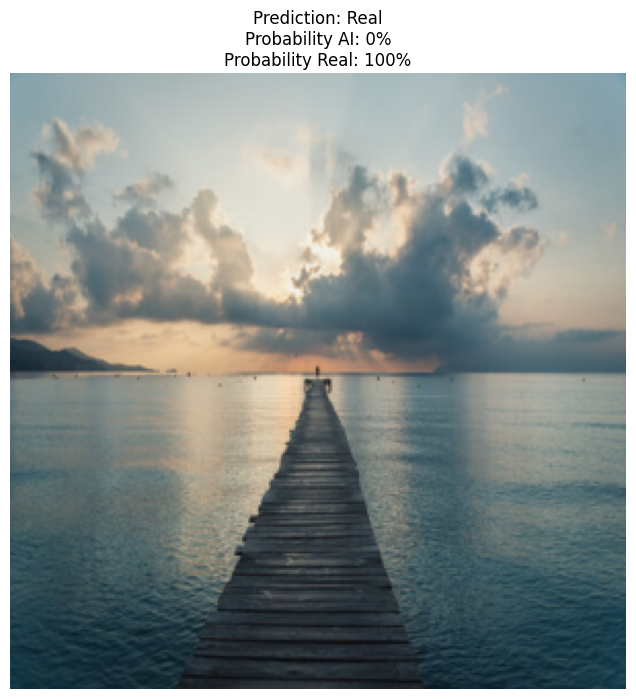


Prediction Results:
Class: Real
Probability AI: 0%
Probability Real: 100%

Enter image path (or 'q' to quit): q


In [ ]:
import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import models
import matplotlib.pyplot as plt

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define model vgg16 seperti pada training
def get_my_vgg16():
    my_vgg16 = models.vgg16(weights=None)

    in_features = my_vgg16.classifier[6].in_features
    my_vgg16.classifier[6] = nn.Sequential(
        nn.Linear(in_features, 100),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(100, 2),
        nn.Softmax(dim=1)
    )
    return my_vgg16

def predict_image(model, image_path):
    # Load dan preprocess gambar
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Lambda(lambda x: x[:3, :, :] if x.size(0) == 4 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Baca dan transform gambar
    try:
        image = read_image(image_path)
        image = transform(image)
        image = image.unsqueeze(0)  # Tambah dimensi batch
        image = image.to(device)

        # Buat prediksi
        model.eval()
        with torch.no_grad():
            prediction = model(image)

        # Dapatkan probabilitas serta class gambar
        prob_ai = prediction[0][1].item()
        prob_real = prediction[0][0].item()
        predicted_class = "AI-generated" if prob_ai > 0.5 else "Real"

        # Display gambar dengan unnormalized image
        display_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
            transforms.Lambda(lambda x: x[:3, :, :] if x.size(0) == 4 else x),
        ])
        display_image = display_transform(read_image(image_path))

        # Display gambar serta hasil prediksi
        plt.figure(figsize=(8, 8))
        plt.imshow(display_image.permute(1, 2, 0))
        plt.title(f'Prediction: {predicted_class}\nProbability AI: {prob_ai:.0%}\nProbability Real: {prob_real:.0%}')
        plt.axis('off')
        plt.show()

        return predicted_class, prob_ai, prob_real

    # Menangani error
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None, None

def main():
    # Load model
    model = get_my_vgg16()
    model.to(device)

    try:
        # Load weights yang tersimpan pada model
        model.load_state_dict(torch.load('BestModel.pth', map_location=device, weights_only= True))
        print("Model loaded successfully!")
        # Menangani error
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return

    # Perulangan input path gambar untuk deteksi gambar
    while True:
        try:
            image_path = input("\nEnter image path (or 'q' to quit): ").strip()

            if image_path.lower() == 'q':
                break

            # Validasi path
            if not os.path.isfile(image_path):
                print("Invalid file path. Please try again.")
                continue

            predicted_class, prob_ai, prob_real = predict_image(model, image_path)

            if predicted_class:
                print(f"\nPrediction Results:")
                print(f"Class: {predicted_class}")
                print(f"Probability AI: {prob_ai:.0%}")
                print(f"Probability Real: {prob_real:.0%}")

        except KeyboardInterrupt:
            print("\nOperation cancelled by user.")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {str(e)}")

# Gunakan fungsi main
if __name__ == "__main__":
    main()